## import needed packages

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import scipy.stats as ss
import numpy.random as npr
from pprint import pprint
import pandas as pd
from collections import defaultdict as ddict

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Real Data 

### the data 

In [3]:
MEM10 = edict()
MEM10.men = edict()
MEM10.pbo= edict()

MEM10.men.n = 107
MEM10.men.mean = 0.77
MEM10.men.sd = 12.06

MEM10.pbo.n = 118
MEM10.pbo.mean = 2.83
MEM10.pbo.sd = 15.70

In [4]:
MEM12 = edict()
MEM12.men = edict()
MEM12.pbo= edict()

MEM12.men.n = 136
MEM12.men.mean = 0.97
MEM12.men.sd = 11.26

MEM12.pbo.n = 125
MEM12.pbo.mean = 0.86
MEM12.pbo.sd = 11.08

In [5]:
MEM02 = edict()
MEM02.men = edict()
MEM02.pbo= edict()

MEM02.men.n = 171
MEM02.men.mean = -0.75
MEM02.men.sd = 11.03

MEM02.pbo.n = 152
MEM02.pbo.mean = 2.78
MEM02.pbo.sd = 13.48

In [6]:
MEM01 = edict()
MEM01.men = edict()
MEM01.pbo= edict()

MEM01.men.n = 133
MEM01.men.mean = -2.11
MEM01.men.sd = 15.12

MEM01.pbo.n = 127
MEM01.pbo.mean = 0.51
MEM01.pbo.sd = 13.75

In [7]:
LU = edict()
LU.men = edict()
LU.pbo= edict()

LU.men.n = 146
LU.men.mean = -0.36
LU.men.sd = 10.40

LU.pbo.n = 64
LU.pbo.mean = -2.23
LU.pbo.sd = 9.55

In [8]:
MRZ = edict()
MRZ.men = edict()
MRZ.pbo= edict()

MRZ.men.n = 97
MRZ.men.mean = 0.09
MRZ.men.sd = 15.92

MRZ.pbo.n = 84
MRZ.pbo.mean = 2.89
MRZ.pbo.sd = 16.13

## New Model

The model is $E[Y_i] =\theta+\beta X_i, \mathrm{Var}(Y_i) =\sigma^2$.

Our target is to estimate the $\beta$. 

I fixed the $\sigma^2$ at the sample variance as it is a nuisance parameter

In [98]:
def DataPre(D):
    D.n = D.men.n + D.pbo.n
    n, n1, n2 = D.n, D.men.n, D.pbo.n
    D.men.mle = D.men.mean
    D.pbo.mle = D.pbo.mean
    mle1, mle2 = D.men.mle, D.pbo.mle
    D.betamle = mle1 - mle2
    D.thetamle = mle2
    D.sigma2mle = (n1*D.men.sd**2+ n2*D.pbo.sd**2)/n
    D.betaUI = n1/n/D.sigma2mle
    D.betainitsigma2 = 1 / (1/100 - n1**2/(D.sigma2mle**2/100+n*D.sigma2mle) + n1/D.sigma2mle)
    D.betainitmean = (n1*mle1/D.sigma2mle-n1*(mle1*n1+mle2*n2)/(D.sigma2mle**2/100+n*D.sigma2mle))*D.betainitsigma2
    return D

In [99]:
MEM01 = DataPre(MEM01)
MEM02 = DataPre(MEM02)
MEM10 = DataPre(MEM10)
MEM12 = DataPre(MEM12)
LU = DataPre(LU)
MRZ = DataPre(MRZ)

### Raw Model

In [11]:
def GetNewRawModel(D):
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    model = pm.Model()
    def loglike(mlem1, mlem2):
        return - (n1*(mlem1-theta-beta)**2 + n2*(mlem2-theta)**2)/2/D.sigma2mle
    
    with model:
        theta = pm.Normal("theta", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)
        # sigma2 = pm.InverseGamma("sigma2", alpha=0.01, beta=0.01)
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlem2":[D.pbo.mle]})
    return model
        

In [12]:
LUmodel = GetNewRawModel(LU)
with LUmodel:
    step = pm.Metropolis()
    trace_LU = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:04<00:00, 13788.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [13]:
MRZmodel = GetNewRawModel(MRZ)
with MRZmodel:
    step = pm.Metropolis()
    trace_MRZ = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:04<00:00, 13955.08draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [14]:
MEM01model = GetNewRawModel(MEM01)
with MEM01model:
    step = pm.Metropolis()
    trace_MEM01 = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:04<00:00, 12271.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [15]:
MEM02model = GetNewRawModel(MEM02)
with MEM02model:
    step = pm.Metropolis()
    trace_MEM02 = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:04<00:00, 13582.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [16]:
MEM10model = GetNewRawModel(MEM10)
with MEM10model:
    step = pm.Metropolis()
    trace_MEM10 = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:04<00:00, 13038.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [17]:
MEM12model = GetNewRawModel(MEM12)
with MEM12model:
    step = pm.Metropolis()
    trace_MEM12= pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:04<00:00, 13629.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [18]:
betas = [trace_LU["beta"], trace_MRZ["beta"], trace_MEM01["beta"], trace_MEM02["beta"], trace_MEM10["beta"], trace_MEM12["beta"]]
thetas = [trace_LU["theta"], trace_MRZ["theta"], trace_MEM01["theta"], trace_MEM02["theta"], trace_MEM10["theta"], trace_MEM12["theta"]]
#sigma2s = [trace_LU["sigma2"], trace_MRZ["sigma2"], trace_MEM01["sigma2"], trace_MEM02["sigma2"], trace_MEM10["sigma2"], trace_MEM12["sigma2"]]

In [19]:
NewRawRes = ddict(list)
NewRawRes["data"] = ["LU", "MRZ", "MEM01", "MEM02", "MEM10", "MEM12"]
for i in range(6):
    NewRawRes["bmean"].append(betas[i].mean())
    NewRawRes["blow"].append(np.quantile(betas[i], 0.025))
    NewRawRes["bup"].append(np.quantile(betas[i], 0.975))
    NewRawRes["tmean"].append(thetas[i].mean())
    NewRawRes["tlow"].append(np.quantile(thetas[i], 0.025))
    NewRawRes["tup"].append(np.quantile(thetas[i], 0.975))
    # NewRawRes["smean"].append(sigma2s[i].mean())
    # NewRawRes["slow"].append(np.quantile(sigma2s[i], 0.025))
    # NewRawRes["sup"].append(np.quantile(sigma2s[i], 0.975))

In [20]:
ResDf = pd.DataFrame(NewRawRes)

In [21]:
ResDf

,data,bmean,blow,bup,tmean,tlow,tup
0,LU,1.771639,-1.149034,4.712422,-2.146088,-4.592776,0.275204
1,MRZ,-2.564739,-7.128267,1.914795,2.740632,-0.567861,6.131129
2,MEM01,-2.472863,-5.966263,0.958347,0.422605,-2.072263,2.922754
3,MEM02,-3.411760,-6.086300,-0.748438,2.698298,0.719656,4.644134
4,MEM10,-1.923586,-5.485028,1.697241,2.739389,0.227936,5.287771
5,MEM12,0.068818,-2.578599,2.663291,0.881024,-1.054626,2.797898


### UIPD model

In [100]:
def getNewUIPDcon(D, Ds):
    nD = len(Ds)
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    
    nhs = np.array([Dh.n for Dh in Ds])
    alps = nhs/n
    alps[alps>=1] = 1
    nsSum = np.sum(nhs)
    betaMeans = [Dh.betamle for Dh in Ds]
    betaUIs = [Dh.betaUI for Dh in Ds]
    thetaMeans = [Dh.thetamle for Dh in Ds]
    UIPDm = pm.Model()
    def loglike(mlem1, mlem2):
        return - (n1*(mlem1-thetah-betah)**2 \
                                        + n2*(mlem2-thetah)**2)/2/D.sigma2mle
    with UIPDm:
        pis = pm.Dirichlet("pis", alps)
        # sigma2 = pm.InverseGamma("sigma2", alpha=0.01, beta=0.01)
        M = pm.Uniform("M", lower=0, upper=n)

        #thetan = 0
        betan = 0
        #sigma2n_inv = 0
        sigma2betan_inv = 0
        for i in range(nD):
            betan += pis[i] * betaMeans[i]
            sigma2betan_inv += M*pis[i] * betaUIs[i]
        sigma2betan = 1/sigma2betan_inv
        thetah = pm.Normal("thetah", mu=0, sigma=10)
        betah = pm.Normal("betah", mu=betan, sigma=np.sqrt(sigma2betan))
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle],  "mlem2":[D.pbo.mle]})
    return UIPDm

### full data

In [101]:
NewModelfull = getNewUIPDcon(MEM12, [LU, MEM01, MEM02, MEM10, MRZ])
with NewModelfull:
    step = pm.Metropolis()
    trace_new_UIPDfull = pm.sample(10000, tune=20000)
    #trace_new_UIPDfull = pm.sample(10000, tune=5000,step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betah, thetah, M, pis]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:34<00:00, 3463.84draws/s]


In [102]:
np.round(np.quantile(trace_new_UIPDfull["thetah"], [0.025, 0.975]), 3)

array([-0.559,  3.008])

In [103]:
np.round(np.quantile(trace_new_UIPDfull["betah"], [0.025, 0.975]), 3)

array([-2.774,  1.643])

In [104]:
np.quantile(trace_new_UIPDfull["M"], [0.025, 0.975])

array([ 13.74296123, 254.5669746 ])

In [105]:
np.quantile(trace_new_UIPDfull["pis"], [0.025, 0.975], axis=0)

array([[0.00472792, 0.00671858, 0.00632811, 0.00390812, 0.00106309],
       [0.66117573, 0.64232606, 0.61597897, 0.62591363, 0.54576212]])

In [106]:
pm.summary(trace_new_UIPDfull)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,1.237,0.904,-0.466,2.946,0.005,0.004,31291.0,29347.0,31313.0,28613.0,1.0
betah,-0.623,1.127,-2.765,1.470,0.007,0.005,29284.0,26071.0,29317.0,28403.0,1.0
pis[0],0.237,0.185,0.000,0.574,0.001,0.001,38565.0,38565.0,31639.0,21342.0,1.0
pis[1],0.217,0.174,0.000,0.540,0.001,0.001,45271.0,39243.0,38359.0,20173.0,1.0
pis[2],0.201,0.165,0.000,0.513,0.001,0.001,42936.0,35436.0,40187.0,23845.0,1.0
pis[3],0.196,0.172,0.000,0.525,0.001,0.001,42080.0,35677.0,41636.0,27083.0,1.0
pis[4],0.148,0.150,0.000,0.439,0.001,0.001,40230.0,33557.0,37283.0,21841.0,1.0
M,137.267,71.794,25.679,260.987,0.357,0.270,40490.0,35419.0,39196.0,21776.0,1.0


In [107]:
pisUIPDs = trace_new_UIPDfull["pis"]

In [108]:
pisUIPD = pisUIPDs.mean(axis=0)

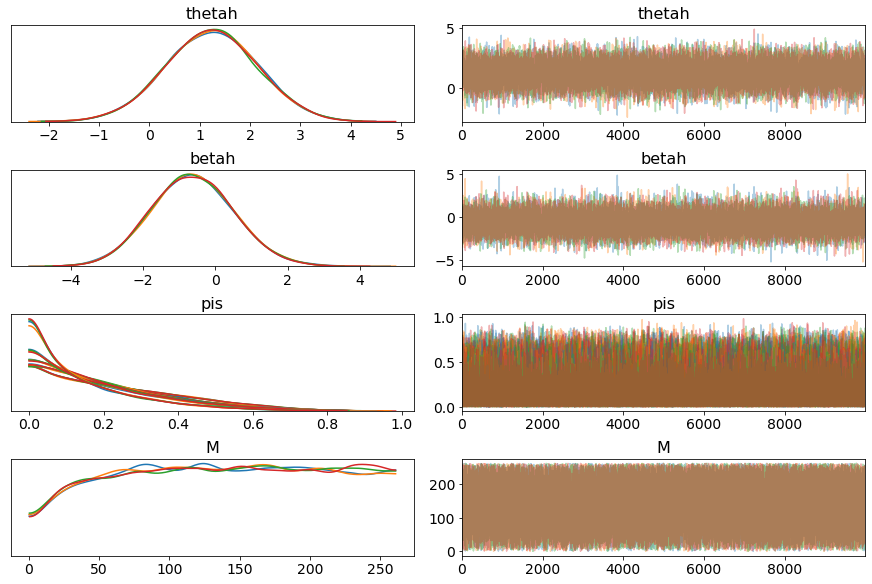

In [109]:
_ = pm.traceplot(trace_new_UIPDfull)

### UIP-JS

In [110]:
def KLnorm(Dc, Dh):
    cmean, hmean = Dc.betainitmean, Dh.betainitmean
    csigma, hsigma = Dc.betainitsigma2**(1/2), Dh.betainitsigma2**(1/2)
    res = np.log(hsigma/csigma) + (csigma**2 + (cmean-hmean)**2)/(2*hsigma**2) - 1/2
    return res

def JSnorm(Dc, Dh):
    KL1 = KLnorm(Dc, Dh)
    KL2 = KLnorm(Dh, Dc)
    return (KL1+KL2)/2

In [111]:
Ds = [LU, MEM01, MEM02, MEM10, MRZ]
D = MEM12 
ds = np.array([JSnorm(D, Dh) for Dh in Ds])
invds = 1/ds
pis = invds / np.sum(invds)
print(ds)
print(pis)

[0.69815087 1.56666426 3.42554941 0.97178299 1.60142765]
[0.35665707 0.1589367  0.0726892  0.2562305  0.15548654]


In [112]:
def getNewUIPJScon(D, Ds):
    nD = len(Ds)
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    
    nsSum = np.sum([Dh.n for Dh in Ds])
    betaMeans = [Dh.betamle for Dh in Ds]
    betaUIs = [Dh.betaUI for Dh in Ds]
    thetaMeans = [Dh.thetamle for Dh in Ds]
    ds = np.array([JSnorm(D, Dh) for Dh in Ds])
    invds = 1/ds
    pis = invds / np.sum(invds)
    
    UIPJSm = pm.Model()
    def loglike(mlem1, mlem2):
        return - (n1*(mlem1-thetah-betah)**2 \
                                        + n2*(mlem2-thetah)**2)/2/D.sigma2mle
    with UIPJSm:
        M = pm.Uniform("M", lower=0, upper=D.n)

        betan = 0
        sigma2betan_inv = 0
        for i in range(nD):
            betan += pis[i] * betaMeans[i]
            sigma2betan_inv += pis[i] * betaUIs[i]
        sigma2betan = 1/M/sigma2betan_inv
        thetah = pm.Normal("thetah", mu=0, sigma=10)
        betah = pm.Normal("betah", mu=betan, sigma=np.sqrt(sigma2betan))
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlem2":[D.pbo.mle]})
    return UIPJSm

In [113]:
NewModelJS = getNewUIPJScon(MEM12, [LU, MRZ, MEM01, MEM02, MEM10])
with NewModelJS:
    step = pm.Metropolis()
    #trace_new_UIPJSfull = pm.sample(10000, tune=20000)
    trace_new_UIPJSfull = pm.sample(10000, tune=20000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [betah]
>Metropolis: [thetah]
>Metropolis: [M]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:09<00:00, 12891.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [114]:
pm.summary(trace_new_UIPJSfull)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,1.129,0.865,-0.504,2.737,0.014,0.010,4033.0,4033.0,4046.0,6233.0,1.0
betah,-0.406,1.001,-2.291,1.480,0.016,0.011,3936.0,3936.0,3972.0,5586.0,1.0
M,145.869,70.261,32.066,260.949,0.807,0.576,7579.0,7446.0,7445.0,7918.0,1.0


In [115]:
np.round(np.quantile(trace_new_UIPJSfull["thetah"], [0.025, 0.975]), 3)

array([-0.587,  2.805])

In [116]:
np.round(np.quantile(trace_new_UIPJSfull["betah"], [0.025, 0.975]), 3)

array([-2.311,  1.663])

In [117]:
np.quantile(trace_new_UIPJSfull["M"], [0.025, 0.975])

array([ 17.68957021, 256.16596703])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f1609c0b8>,
      dtype=object)

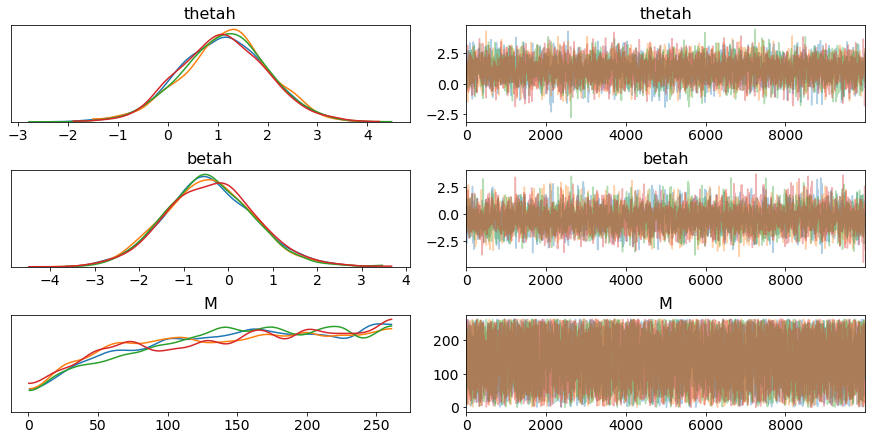

In [118]:
pm.traceplot(trace_new_UIPJSfull)

###  MPP

In [41]:
def getNewMPPcon(D, Ds):
    nD = len(Ds)
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    
    mMens = [Dh.men.mean for Dh in Ds]
    nMens = [Dh.men.n for Dh in Ds]
    sigma2MLEs = [Dh.sigma2mle for Dh in Ds]
    
    MPPm = pm.Model()
    def loglike(mlem1, mlem2):
        return - (n1*(mlem1-thetah-betah)**2 \
                                        + n2*(mlem2-thetah)**2)/2/D.sigma2mle
    with MPPm:
        # sigma2 = pm.InverseGamma("sigma2", alpha=0.01, beta=0.01)
        gammas = pm.Uniform("gammas", lower=0, upper=1, shape=nD)
        thetah = pm.Normal("thetah", mu=0, sigma=10)

        betanNum = 0
        sigma2betan_inv = 0
        for i in range(nD):
            betanNum += gammas[i]*nMens[i]*(mMens[i]-thetah)/sigma2MLEs[i]
            sigma2betan_inv += gammas[i]*nMens[i]/sigma2MLEs[i]
            
        sigma2betan = 1/sigma2betan_inv
        betan = betanNum/sigma2betan_inv
        
        betah = pm.Normal("betah", mu=betan, sigma=np.sqrt(sigma2betan))
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlem2":[D.pbo.mle]})
    return MPPm

In [42]:
NewModelMPP = getNewMPPcon(MEM12, [LU, MRZ, MEM01, MEM02, MEM10])
with NewModelMPP:
    step = pm.Metropolis()
    trace_new_MPPfull = pm.sample(10000, tune=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betah, thetah, gammas]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:25<00:00, 4658.14draws/s]
The acceptance probability does not match the target. It is 0.7115014647276164, but should be close to 0.8. Try to increase the number of tuning steps.


In [43]:
np.round(np.quantile(trace_new_MPPfull["thetah"], [0.025, 0.975]), 3)

array([-1.059,  2.8  ])

In [44]:
np.round(np.quantile(trace_new_MPPfull["betah"], [0.025, 0.975]), 3)

array([-3.084,  1.421])

In [45]:
np.quantile(trace_new_MPPfull["gammas"], [0.025, 0.975], axis=0)

array([[0.02611539, 0.02494823, 0.01847762, 0.02184737, 0.02907708],
       [0.97430758, 0.97707826, 0.96743014, 0.97267393, 0.97810246]])

In [46]:
pm.summary(trace_new_MPPfull)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,0.857,0.989,-0.985,2.694,0.005,0.004,34143.0,27021.0,34147.0,28889.0,1.0
betah,-0.828,1.160,-2.978,1.351,0.006,0.005,33136.0,25241.0,33147.0,29063.0,1.0
gammas[0],0.503,0.287,0.037,0.975,0.001,0.001,51833.0,42589.0,47899.0,22717.0,1.0
gammas[1],0.509,0.290,0.063,1.000,0.001,0.001,54711.0,46856.0,50309.0,23340.0,1.0
gammas[2],0.453,0.288,0.000,0.924,0.001,0.001,51260.0,40287.0,47106.0,24917.0,1.0
gammas[3],0.484,0.289,0.000,0.932,0.001,0.001,56254.0,44513.0,51833.0,23774.0,1.0
gammas[4],0.527,0.288,0.070,1.000,0.001,0.001,54623.0,47025.0,50879.0,25379.0,1.0


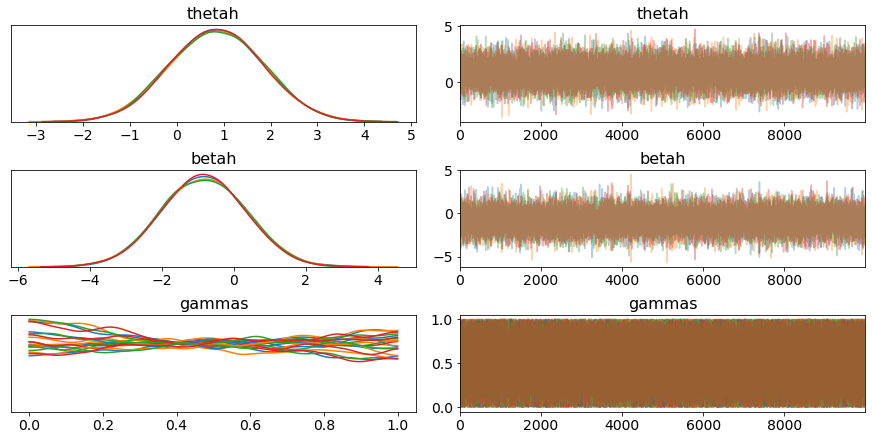

In [47]:
_ = pm.traceplot(trace_new_MPPfull)

### LCP

In [48]:
def getNewLCPcon(D, Ds):
    nD = len(Ds)
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    
    mMens = [Dh.men.mean for Dh in Ds]
    mPbos = [Dh.pbo.mean for Dh in Ds]
    nMens = [Dh.men.n for Dh in Ds]
    sigma2MLEs = [Dh.sigma2mle for Dh in Ds]
    
    LCPm = pm.Model()
    def loglike(mlem1, mlem2):
        return - (n1*(mlem1-thetah-betah)**2 \
                                        + n2*(mlem2-thetah)**2)/2/D.sigma2mle
    with LCPm:
        # sigma2 = pm.InverseGamma("sigma2", alpha=0.01, beta=0.01)
        thetah = pm.Normal("thetah", mu=0, sigma=10)
        logtaus = pm.Uniform("logtaus", lower=-30, upper=30, shape=nD)

        betanNum = 0
        sigma2betan_inv = 0
        for i in range(nD):
            taui = np.exp(logtaus[i])
            sigma2LCPinv = (nMens[i]*taui)/(sigma2MLEs[i]*taui + nMens[i])
            mi =mMens[i] - mPbos[i]
            
            betanNum += mi * sigma2LCPinv
            sigma2betan_inv += sigma2LCPinv
            
        sigma2betan = 1/sigma2betan_inv
        betan = betanNum/sigma2betan_inv
        
        betah = pm.Normal("betah", mu=betan, sigma=np.sqrt(sigma2betan))
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlem2":[D.pbo.mle]})
    return LCPm

In [49]:
NewModelLCP = getNewLCPcon(MEM12, [LU, MRZ, MEM01, MEM02, MEM10])
with NewModelLCP:
    step = pm.Metropolis()
    trace_new_LCPfull = pm.sample(10000, tune=20000, 
                                  #target_accept=0.95,
                                 step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [betah]
>Metropolis: [logtaus]
>Metropolis: [thetah]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:08<00:00, 14851.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [50]:
np.round(np.quantile(trace_new_LCPfull["thetah"], [0.025, 0.975]), 3)

array([-0.49 ,  2.886])

In [51]:
np.round(np.quantile(trace_new_LCPfull["betah"], [0.025, 0.975]), 3)

array([-2.691,  1.472])

In [52]:
np.quantile(trace_new_LCPfull["logtaus"], [0.025, 0.975], axis=0)

array([[-25.05287451, -28.53506737, -28.83065877, -28.83847215,
        -28.4952585 ],
       [ 29.2617482 ,  28.65100095,  28.41907412,  28.06207783,
         28.81908395]])

In [53]:
pm.summary(trace_new_LCPfull)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,1.187,0.872,-0.432,2.820,0.019,0.014,2101.0,2085.0,2105.0,3865.0,1.00
betah,-0.511,1.014,-2.526,1.419,0.031,0.022,1100.0,1100.0,1110.0,1549.0,1.00
logtaus[0],9.966,14.098,-19.002,29.999,0.434,0.307,1057.0,1057.0,1126.0,1752.0,1.00
logtaus[1],0.030,17.403,-29.473,26.989,0.484,0.342,1295.0,1295.0,1197.0,1593.0,1.00
logtaus[2],-0.344,17.343,-29.884,26.325,0.467,0.330,1382.0,1382.0,1259.0,2095.0,1.01
logtaus[3],-2.302,17.117,-29.983,25.387,0.531,0.375,1040.0,1040.0,1006.0,1886.0,1.01
logtaus[4],1.363,17.506,-26.061,29.937,0.499,0.353,1233.0,1233.0,1153.0,1902.0,1.00


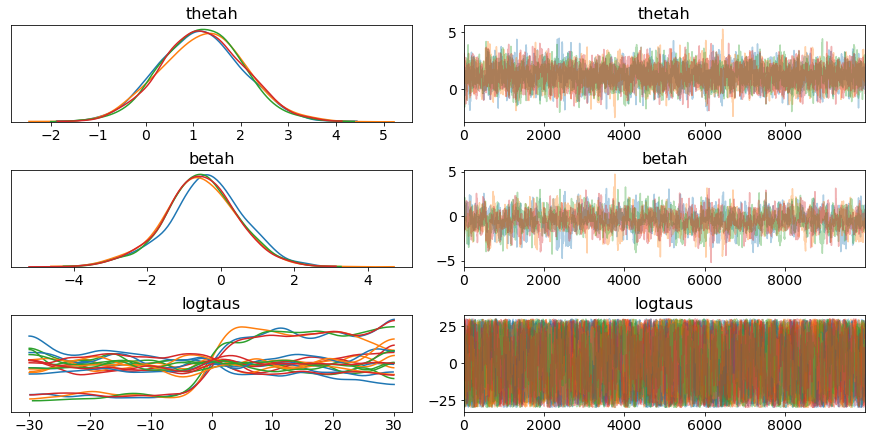

In [54]:
_ = pm.traceplot(trace_new_LCPfull)

## rMAP

In [55]:
from rpy2 import robjects as robj

In [56]:
def DataPrerMAP(D):
    n = D.n
    n1 = D.men.n
    D.betaVar = D.sigma2mle*n/(n*n1 - n1*n1)
    return D

In [57]:
MEM01 = DataPrerMAP(MEM01)
MEM02 = DataPrerMAP(MEM02)
MEM10 = DataPrerMAP(MEM10)
MEM12 = DataPrerMAP(MEM12)
LU = DataPrerMAP(LU)
MRZ = DataPrerMAP(MRZ)

In [58]:
def HistPrerMAP(Ds):
    ys = []
    ns = []
    y_ses = []
    for Dh in Ds:
        ys.append(Dh.betamle)
        ns.append(Dh.n)
        y_ses.append(np.sqrt(Dh.betaVar))
    DF = ys + y_ses + ns
    Rmat = robj.r.matrix(robj.FloatVector(DF), nrow=3, byrow=True)
    return Rmat

In [59]:
def getMixNorm(Ds, mean, w=0.1):
    robj.r.source("MAPNorm.R")
    Rmat = HistPrerMAP(Ds)
    rmap = robj.r.getrMAPNormal(Ds=Rmat, w=w, mean=mean)
    return np.array(rmap)

In [60]:
Ds = [LU, MRZ, MEM01, MEM02, MEM10]

In [62]:
def getNewrMAPcon(D, paras):
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    
    ws = paras[0, :]
    mus = paras[1, :]
    sigmas = paras[2, :]
    
    rMAPm = pm.Model()
    def loglike(mlem1, mlem2):
        return - (n1*(mlem1-thetah-betah)**2 \
                                        + n2*(mlem2-thetah)**2)/2/D.sigma2mle
    with rMAPm:
        thetah = pm.Normal("thetah", mu=0, sigma=10)

        norm_comps = pm.Normal.dist(mu=mus, sigma=sigmas, shape=len(mus))
        betah = pm.Mixture("betah", w=ws, comp_dists=norm_comps)
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlem2":[D.pbo.mle]})
    return rMAPm

In [63]:
paras = getMixNorm(Ds, mean=0.110, w=0.1)

R[write to console]: Loading required package: Rcpp

R[write to console]: This is RBesT version 1.6.1

R[write to console]: Using default prior reference scale 26.2697531065813



In [64]:
NewModelrMAP = getNewrMAPcon(MEM12, paras)
with NewModelrMAP:
    step = pm.Metropolis()
    trace_new_rMAPfull = pm.sample(10000, tune=20000, 
                                  #target_accept=0.95,
                                 step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [betah]
>Metropolis: [thetah]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [00:09<00:00, 12870.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [65]:
np.round(np.quantile(trace_new_rMAPfull["thetah"], [0.025, 0.975]), 3)

array([-0.69 ,  2.943])

In [66]:
np.round(np.quantile(trace_new_rMAPfull["betah"], [0.025, 0.975]), 3)

array([-2.631,  2.054])

In [67]:
pm.summary(trace_new_rMAPfull)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,1.163,0.928,-0.647,2.835,0.016,0.011,3435.0,3435.0,3451.0,5521.0,1.0
betah,-0.482,1.206,-2.605,1.875,0.021,0.015,3303.0,3303.0,3339.0,5131.0,1.0


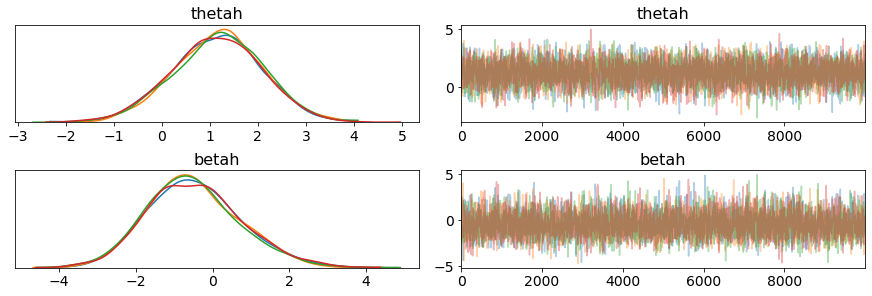

In [68]:
_ = pm.traceplot(trace_new_rMAPfull)